In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import time

In [3]:
import spacy

In [4]:
spacy.prefer_gpu()

False

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Sprawdzanie czy w systemie jest karta graficzna Nvidia - CUDA

In [6]:
cuda_av = torch.cuda.is_available()
cuda_av

True

In [7]:
if cuda_av:
    cuda_id = torch.cuda.current_device()
    print(f'ID urządzenia CUDA: {cuda_id}')
    print(f"Nazwa urządzenia CUDA: {torch.cuda.get_device_name(cuda_id)}")

ID urządzenia CUDA: 0
Nazwa urządzenia CUDA: NVIDIA GeForce GTX 1070


In [8]:
# Tworzenie kodu uniwersalnego: dla CUDA i CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Ładowanie danych treningowych

In [9]:
tweets = pd.read_csv('data/olid-training-v1.0.tsv', sep='\t')

In [10]:
tweets.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [11]:
# tweets = tweets[:100]

In [12]:
# tweets = tweets[:5]

### usuwanie tweetow gdzie kulumna subtask_b jest nan

In [ ]:
len(tweets)

In [13]:
tweets = tweets.dropna(subset=['subtask_b'])

In [14]:
len(tweets)

4400

### Tokenizacja, lematyzacja, usówanie pewnych słów
liczenie najdłuższego przetworzonego tweeta

In [15]:
nlp = spacy.load('en_core_web_sm')

In [16]:
# dodawanie kolumny z tokenami
tweets['tokens'] = tweets['tweet'].apply(nlp)

In [17]:
tweets.head()

,id,tweet,subtask_a,subtask_b,subtask_c,tokens
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"(@USER, She, should, ask, a, few, native, Amer..."
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"(@USER, @USER, Go, home, you, ’re, drunk, !, !..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"(@USER, Someone, should'veTaken, "", this, piec..."
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH,"(@USER, Liberals, are, all, Kookoo, !, !, !)"
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN,"(@USER, @USER, Oh, noes, !, Tough, shit, .)"


In [18]:
# dodawanie kolumny z lematami za pomoca funkcji lambda - przy tym usuwanie:
# odwolan do wczesniejszych tweetow (zawiera @)
# - slowa url (czyli adresy stron inernetowych które w danych wejściowych mają URL zamiast adreasu.
# # - hasztagów; przyimków i innych częstych słów (stop words) oraz znaków interpunkcyjnych.
# spacji ' ', '  ', '   '

# emotikony zostawiam - uważam, że też niosą znaczenie

tweets['lemmas'] = tweets['tokens'].apply\
    (lambda list_tokens : [token.lemma_.strip() for token in list_tokens if ('@' not in token.lemma_ \
                                                                     and '#' not in token.lemma_ and 'url' not in token.lemma_ \
                                                                     and not token.is_stop and not token.is_punct and token.lemma_ != ' ' \
                                                                     and token.lemma_ != '  ' and token.lemma_ != '   '
                                                                     and token.lemma_ != '    ' and token.lemma_.strip() != '')])

In [19]:
tweets

,id,tweet,subtask_a,subtask_b,subtask_c,tokens,lemmas
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"(@USER, She, should, ask, a, few, native, Amer...","[ask, native, Americans]"
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"(@USER, @USER, Go, home, you, ’re, drunk, !, !...","[home, drunk, MAGA, Trump2020, 👊, 🇺, 🇸, 👊]"
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"(@USER, Someone, should'veTaken, "", this, piec...","[should'vetaken, piece, shit, volcano, 😂]"
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH,"(@USER, Liberals, are, all, Kookoo, !, !, !)","[liberal, Kookoo]"
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN,"(@USER, @USER, Oh, noes, !, Tough, shit, .)","[oh, no, tough, shit]"
...,...,...,...,...,...,...,...
13223,63482,@USER is advocating for conduct within bounds ...,OFF,TIN,GRP,"(@USER, is, advocating, for, conduct, within, ...","[advocate, conduct, bound, Human, Rights, terr..."
13227,87416,@USER @USER @USER @USER Liars like the Antifa ...,OFF,TIN,GRP,"(@USER, @USER, @USER, @USER, Liars, like, the,...","[liar, like, Antifa, twin, vigorously, defend]"
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND,"(@USER, Sometimes, I, get, strong, vibes, from...","[strong, vibe, people, man, vibe, ten, million..."
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH,"(@USER, And, why, report, this, garbage, ., ,...","[report, garbage, crap]"


In [20]:
# for index, row in tweets.iterrows():
#     for word in row['lemmas']:
#         if word == '':
#             print(index)

In [21]:
# tweets.iloc[499, 6]

In [22]:
# if tweets.iloc[500, 6][0] == '':
#     print(True)

In [23]:
# tweets.iloc[500, 6]

In [24]:
# tweets.loc[:3,'lemmas']

In [25]:
tweets.iloc[5:20]

,id,tweet,subtask_a,subtask_b,subtask_c,tokens,lemmas
7,52415,@USER was literally just talking about this lo...,OFF,TIN,GRP,"(@USER, was, literally, just, talking, about, ...","[literally, talk, lol, mass, shooting, like, s..."
9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND,"(@USER, Canada, does, n’t, need, another, CUCK...","[Canada, need, CUCK, LooneyLeft, Liberals, f**..."
12,28414,@USER you are a lying corrupt traitor!!! Nobod...,OFF,TIN,IND,"(@USER, you, are, a, lying, corrupt, traitor, ...","[lie, corrupt, traitor, want, hear, anymore, l..."
19,28195,@USER @USER @USER gun control! That is all the...,OFF,TIN,OTH,"(@USER, @USER, @USER, gun, control, !, That, i...","[gun, control, kid, ask]"
20,56117,@USER @USER @USER @USER LOL!!! Throwing the ...,OFF,TIN,IND,"(@USER, @USER, @USER, @USER, LOL, !, !, !, ,...","[LOL, throw, BULLSHIT, Flag, nonsense, putupor..."
22,12681,@USER @USER Kind of like when conservatives wa...,OFF,TIN,GRP,"(@USER, @USER, Kind, of, like, when, conservat...","[kind, like, conservative, wanna, associate, l..."
23,82904,@USER @USER Da fuck is going on people? Ther...,OFF,TIN,GRP,"(@USER, @USER, Da, fuck, is, going, on, people...","[Da, fuck, go, people, man, room, woman, room,..."
25,77665,@USER Tbh these days i just don't like people ...,OFF,TIN,IND,"(@USER, Tbh, these, days, i, just, do, n't, li...","[tbh, day, like, people, general, connect, peo..."
29,25440,@USER @USER @USER She? To whom are you referr...,OFF,UNT,NaN,"(@USER, @USER, @USER, She, ?, , To, whom, are...","[refer, Hillary, know, tiresome, Bernie, suppo..."
32,12609,The only thing the Democrats have is lying and...,OFF,TIN,GRP,"(The, only, thing, the, Democrats, have, is, l...","[thing, Democrats, lie, stall, stop, Trump, Pr..."


In [26]:
tweets['length_lemmas'] = tweets['lemmas'].apply(lambda row: len(row))

In [27]:
tweets.loc[:10, 'length_lemmas']

0     3
1     8
3     5
5     2
6     4
7    16
9    10
Name: length_lemmas, dtype: int64

In [28]:
max_length_tweet = max(tweets['length_lemmas'])

## Ładowanie danych testowych(b)

In [29]:
test_level_b = pd.read_csv('data/testset-levelb.tsv', sep='\t')

In [30]:
labels_level_b = pd.read_csv('data/labels-levelb.csv', header=None)

In [31]:
labels_level_b = labels_level_b.rename(columns={0:'id', 1:'subtask_b'})

In [32]:
test_b = pd.merge(test_level_b, labels_level_b, on = "id", how = "inner")

In [33]:
test_b.head()

,id,tweet,subtask_b
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,TIN
1,60133,#NoPasaran: Unity demo to oppose the far-right...,TIN
2,83681,. . . What the fuck did he do this time?,TIN
3,65507,@USER Do you get the feeling he is kissing @US...,TIN
4,12588,@USER Nigga ware da hits at,UNT


In [34]:
len(test_b)

240

In [35]:
test_b = test_b.dropna(subset=['subtask_b'])

In [36]:
len(test_b)

240

### Opracowanie danych testowych (część a)
Takie same modyfikacje jak dla danych treningowych

In [37]:
test_b['tokens'] = test_b['tweet'].apply(nlp)
test_b['lemmas'] = test_b['tokens'].apply \
    (lambda list_tokens : [token.lemma_.strip() for token in list_tokens if ('@' not in token.lemma_
                                                                             and '#' not in token.lemma_ and 'url' not in token.lemma_
                                                                             and not token.is_stop and not token.is_punct and token.lemma_ != ' '
                                                                             and token.lemma_ != '  ' and token.lemma_ != '   '
                                                                             and token.lemma_ != '    ' and token.lemma_.strip() != '')])



In [38]:
test_b['length_lemmas'] = test_b['lemmas'].apply(lambda row: len(row))

In [39]:
max(test_b['length_lemmas'])

40

In [40]:
test_b.head()

,id,tweet,subtask_b,tokens,lemmas,length_lemmas
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,TIN,"(#, WhoIsQ, #, WheresTheServer, #, DumpNike, #...","[WhoIsQ, wherestheserver, DumpNike, DECLASFISA...",24
1,60133,#NoPasaran: Unity demo to oppose the far-right...,TIN,"(#, NoPasaran, :, Unity, demo, to, oppose, the...","[NoPasaran, unity, demo, oppose, far, right, L...",9
2,83681,. . . What the fuck did he do this time?,TIN,"(., ., ., What, the, fuck, did, he, do, this, ...","[fuck, time]",2
3,65507,@USER Do you get the feeling he is kissing @US...,TIN,"(@USER, Do, you, get, the, feeling, he, is, ki...","[feeling, kiss, humiliate, later]",4
4,12588,@USER Nigga ware da hits at,UNT,"(@USER, Nigga, ware, da, hits, at)","[Nigga, ware, da, hit]",4


In [41]:
len(test_b)

240

In [42]:
max_length_tweet_test = max(test_b['length_lemmas'])

In [43]:
max_length_tweet_test

40

#### Maksymalna długość wektora z lematami z tweetów

In [44]:
max_width = max(max_length_tweet, max_length_tweet_test)

## Funkcje do przekszałcania danych

In [45]:
def convert_words_to_numbers(lemmas_series, dict_ = dict()):
    # dict_ = dict()
    for row in lemmas_series:
        for lemma in row:
            if lemma not in dict_:
                dict_[lemma] = len(dict_) + 1

    return dict_

In [46]:
def lemmas_to_numbers(row, max_list_lemmas, dict_):
    list_numbers = []
    for i in range(max_list_lemmas - len(row)):
        list_numbers.append(0)

    for lemma in row:
        list_numbers.append(dict_[lemma])

    array_numbers = np.array(list_numbers, dtype=np.int32)
    return array_numbers

## Powrót do opracowywania danych treningowych

In [47]:
dict_lemmas = convert_words_to_numbers(tweets['lemmas'])

In [48]:
sorted(dict_lemmas)[:10]

['$',
 "'em",
 '+',
 '-Antifa',
 '-Awkward',
 '-Bill',
 '-GOP',
 '-Human',
 '-I',
 '-Illegal']

In [49]:
# zamiana lematu na liczbe ze slownika ktory odpowiada danemu slowu
tweets['numbers'] = tweets['lemmas'].apply(lambda row : lemmas_to_numbers(row, max_width, dict_lemmas))

In [50]:
tweets['numbers'].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: numbers, dtype: object

In [51]:
# przypisywanie X_train kolumny numbers skonwertowanej na tablice numpy
X_train = tweets['numbers'].values

In [52]:
# łączenie wierszy tablic w jedną tablicę 2D
X_train = np.stack(X_train)

In [53]:
# konwertowanie tablicy 2d do tensora
X_train = torch.FloatTensor(X_train)

In [54]:
# ustawianie kolumn z etykietami na poszczególne zadania jako type które przechowują kategorie

In [55]:
cat_cols = ['subtask_a', 'subtask_b', 'subtask_c']

In [56]:
for col in cat_cols:
    tweets[col] = tweets[col].astype('category')

In [57]:
tweets['labels_b'] = tweets['subtask_b'].cat.codes

In [58]:
# OFFENSIVE jest jako 1, a NOT OFFENSIVE jest jako 0
tweets.loc[:5, 'labels_b']

0    1
1    0
3    1
5    0
Name: labels_b, dtype: int8

In [59]:
tweets

,id,tweet,subtask_a,subtask_b,subtask_c,tokens,lemmas,length_lemmas,numbers,labels_b
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"(@USER, She, should, ask, a, few, native, Amer...","[ask, native, Americans]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"(@USER, @USER, Go, home, you, ’re, drunk, !, !...","[home, drunk, MAGA, Trump2020, 👊, 🇺, 🇸, 👊]",8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"(@USER, Someone, should'veTaken, "", this, piec...","[should'vetaken, piece, shit, volcano, 😂]",5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH,"(@USER, Liberals, are, all, Kookoo, !, !, !)","[liberal, Kookoo]",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN,"(@USER, @USER, Oh, noes, !, Tough, shit, .)","[oh, no, tough, shit]",4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...,...,...,...,...,...
13223,63482,@USER is advocating for conduct within bounds ...,OFF,TIN,GRP,"(@USER, is, advocating, for, conduct, within, ...","[advocate, conduct, bound, Human, Rights, terr...",23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
13227,87416,@USER @USER @USER @USER Liars like the Antifa ...,OFF,TIN,GRP,"(@USER, @USER, @USER, @USER, Liars, like, the,...","[liar, like, Antifa, twin, vigorously, defend]",6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND,"(@USER, Sometimes, I, get, strong, vibes, from...","[strong, vibe, people, man, vibe, ten, million...",10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH,"(@USER, And, why, report, this, garbage, ., ,...","[report, garbage, crap]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [60]:
tweets.iloc[0]

id                                                           86426
tweet            @USER She should ask a few native Americans wh...
subtask_a                                                      OFF
subtask_b                                                      UNT
subtask_c                                                      NaN
tokens           (@USER, She, should, ask, a, few, native, Amer...
lemmas                                    [ask, native, Americans]
length_lemmas                                                    3
numbers          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
labels_b                                                         1
Name: 0, dtype: object

In [61]:
y_train = tweets['labels_b'].values

In [62]:
y_train = torch.tensor(y_train).reshape(-1,1)

In [63]:
y_train[:5]

tensor([[1],
        [0],
        [1],
        [0],
        [1]], dtype=torch.int8)

In [64]:
data = torch.cat((X_train, y_train), axis=1)

In [65]:
data = data.to(device)

## Opracowywanie danych testowych

In [66]:
dict_lemmas = convert_words_to_numbers(test_b['lemmas'], dict_lemmas)

In [67]:
sorted(dict_lemmas)[:10]

['$',
 "'cause",
 "'em",
 '+',
 '-Antifa',
 '-Awkward',
 '-Bill',
 '-GOP',
 '-Human',
 '-I']

In [68]:
# zamiana lematu na liczbe ze slownika ktory odpowiada danemu slowu
test_b['numbers'] = test_b['lemmas'].apply(lambda row : lemmas_to_numbers(row, max_width, dict_lemmas))

In [69]:
test_b['lemmas'].head()

0    [WhoIsQ, wherestheserver, DumpNike, DECLASFISA...
1    [NoPasaran, unity, demo, oppose, far, right, L...
2                                         [fuck, time]
3                    [feeling, kiss, humiliate, later]
4                               [Nigga, ware, da, hit]
Name: lemmas, dtype: object

In [70]:
test_b.loc[:5, 'numbers']

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: numbers, dtype: object

### Robienie tego samego procesu co wcześniej dla danych testowych


In [71]:
X_test = test_b['numbers'].values

In [72]:
X_test = np.stack(X_test)

In [73]:
X_test = torch.FloatTensor(X_test)

In [74]:
# cat_cols = ['subtask_a', 'subtask_b', 'subtask_c']
# for col in cat_cols:
#     X_test[col] = X_test[col].astype('category')

In [75]:
test_b['subtask_b'] = test_b['subtask_b'].astype('category')

In [76]:
test_b['labels_b'] = test_b['subtask_b'].cat.codes

In [77]:
# OFFENSIVE jest jako 1, a NOT OFFENSIVE jest jako 0
test_b.loc[:100, 'labels_b']

0      0
1      0
2      0
3      0
4      1
      ..
96     0
97     0
98     0
99     0
100    0
Name: labels_b, Length: 101, dtype: int8

In [78]:
y_test = test_b['labels_b'].values

In [79]:
y_test = torch.tensor(y_test).reshape(-1,1)

In [80]:
y_test[:5]

tensor([[0],
        [0],
        [0],
        [0],
        [1]], dtype=torch.int8)

In [81]:
data_test_b = torch.cat((X_test, y_test), axis=1)

In [82]:
data_test_b = data_test_b.to(device)

## Generowanie embedingów na podstawie embedingów ze spacy

In [83]:
embeddings = []

In [84]:
embeddings.append(np.zeros(96))

In [85]:
for key, value in dict_lemmas.items():
    embeddings.append(nlp(key)[0].vector)
    # print(key)

In [86]:
# embeddings

In [87]:
len(dict_lemmas)

10528

In [88]:
dict_lemmas_inverted = {v: k for k, v in dict_lemmas.items()}

In [89]:
# dict_lemmas_inverted

In [90]:
# sprawdzanie embeddingów - czy się dobrze zapisały
for key, value in dict_lemmas.items():
    comparison = embeddings[value] == nlp(key)[0].vector
    if comparison.all() == False:
        print('false')

print('finished')


finished


In [91]:
embeddings[1]

array([-0.676073  ,  0.09062457, -0.19625556,  0.9512366 ,  0.7504209 ,
        1.1548312 ,  1.0129769 , -0.8388504 , -1.1186899 ,  0.71350086,
       -0.4241021 , -0.30965236,  0.12993638, -0.2392391 , -1.0840138 ,
        0.61949897,  0.04032705, -0.10979578, -1.0923057 , -0.11414534,
       -0.20071098,  0.01481187, -0.4070547 , -0.3393178 , -0.19887975,
       -0.00512362, -0.44030216, -0.26272678, -0.51703787,  0.02113847,
       -0.84284085, -0.33209977,  0.92871165, -0.4222517 ,  0.4632333 ,
       -0.5070641 ,  1.0883812 ,  0.53153765, -0.6991434 , -0.24793866,
        0.2177751 ,  0.76133025, -0.2888482 ,  1.6803848 ,  1.1069292 ,
       -0.44316196,  0.4076068 , -0.2660989 , -0.54845977, -0.55120814,
        0.23734902,  0.02351934,  0.45318043,  0.856611  ,  0.29240057,
       -1.0060917 ,  1.32265   , -1.1334491 ,  0.20376281, -0.6440315 ,
        0.41097862,  0.3831125 ,  1.1056539 , -0.34738913,  0.60588783,
       -0.09251603, -0.41251144, -0.6224398 ,  0.683713  ,  0.34

In [92]:
emb_torch = torch.tensor(embeddings, dtype=torch.float32, device=device)

In [93]:
emb_torch.shape

torch.Size([10529, 96])

## Definiowanie modelu

In [94]:
class Model(nn.Module):
    def __init__(self, emb_vectors, in_features=18, h1=80, h2=50, h3=None, embedding_dim=None, out_features=1):
        super().__init__()

        # warstwa embeddingów wczytująca embeddingi przekazane przy tworzeniu modelu
        self.embedding = nn.Embedding.from_pretrained(emb_vectors)

        # self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # dropout layer - losowe pomijanie uczenia się pewnych neuronów
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(embedding_dim * in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        if h3 is None:
            self.out = nn.Linear(h2, out_features)
        # self.sig = nn.Sigmoid()
        else:
            self.fc3 = nn.Linear(h2, h3)
            self.out = nn.Linear(h3, out_features)


    def forward(self, x):
        # print(x.shape)
        x = x.long()
        # print(x.shape)
        embeds = self.embedding(x)
        
        # print(embeds.shape)
        embeds = embeds.view(embeds.shape[0], -1)
        # print(embeds.shape)
        x = torch.sigmoid(self.fc1(embeds))
        
        x = self.dropout(x)
        
        # x = self.dropout(x)

        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)

        if h3 is not None:
            x = torch.sigmoid(self.fc3(x))
            x = self.dropout(x)
        x = torch.sigmoid(self.out(x))

        return x

## Ustawnia modelu i sieci

In [95]:
print('max width: 73')

max width: 73


In [96]:
epochs = 100
learning_rate = 0.001
batch_size = 50
vocab_size = len(dict_lemmas) + 1
embedding_dim = emb_torch.shape[1]
h1 = 1000
h2 = 1000
h3 = None


In [97]:
train_dataset_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
test_dataset_loader_b = torch.utils.data.DataLoader(data_test_b, batch_size=batch_size, shuffle=True)

## Tworzenie instancji modelu
Ustawianie funkcji straty i optymalizatora

In [98]:
# tworzenie numpy array z listy liczb (odpowiadających lematom)

In [99]:
max_width

40

In [100]:
torch.manual_seed(32)
model = Model(emb_torch, max_width, h1, h2, h3, embedding_dim)

In [101]:
model = model.to(device)

In [102]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [103]:
model

Model(
  (embedding): Embedding(10529, 96)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3840, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (out): Linear(in_features=1000, out_features=1, bias=True)
)

### Ustawianie nauki sieci i samo uczenie się

In [104]:
losses = []
losses_test = []
accuracy = []
accuracy_test = []
train_count = len(tweets)
test_count_a = len(test_b)

In [105]:
start_time = time.time()
for e in range(epochs):
    loss_epoch = torch.empty(0)
    correct_epoch = 0

    loss_epoch_test = np.empty(0)
    correct_epoch_test = 0

    for batch_num, batch in enumerate(train_dataset_loader):
        X_train = batch[:,:-1]
        y_train = batch[:,-1].reshape(-1,1)
        y_pred = model.forward(X_train)

        loss = criterion(y_pred, y_train)
        if (e == 0 and batch_num == 0):
            print(f'Loss on the first batch: {loss}')

        # print(loss.item())
        loss_epoch = np.append(loss_epoch, loss.detach().cpu().numpy())
        # losses.append(loss.item())


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        predicted = torch.round(y_pred)
        # print(y_train)
        predicted = (predicted == y_train).sum().cpu()
        pred_cpu = predicted.cpu()
        # print(f'pred_cpu: {pred_cpu}')
        correct_epoch += predicted

# przechodzenie przez dane testowe
    with torch.no_grad():
        for batch_num_test, batch_test in enumerate(test_dataset_loader_b):
            X_test = batch_test[:,:-1]
            y_test = batch_test[:,-1].reshape(-1,1)
            y_pred_test = model.forward(X_test)

            loss_test = criterion(y_pred_test, y_test)
            if (e == 0 and batch_num_test == 0):
                print(f'Loss on the first batch on test data: {loss_test}')
                print(loss_test.shape)

            # print(loss.item())
            loss_epoch_test = np.append(loss_epoch_test, loss_test.item())
            # print(loss_test)
            # losses.append(loss.item())

            predicted = torch.round(y_pred_test)
            # print(predicted)
            # print(y_test)
            predicted = (predicted == y_test).sum()
            pred_cpu = predicted.cpu()
            # print(f'pred_cpu: {pred_cpu}')
            correct_epoch_test += predicted

        loss_epoch_test = loss_epoch_test.sum() / test_count_a
        losses_test.append(loss_epoch_test)
        accuracy_epoch_test = correct_epoch_test * 100/test_count_a
        accuracy_epoch_test_cpu = accuracy_epoch_test.cpu()
        accuracy_test.append(accuracy_epoch_test_cpu)

    loss_epoch = loss_epoch.sum() / train_count
    losses.append(loss_epoch)
    accuracy_epoch = correct_epoch * 100/train_count
    accuracy_epoch_cpu = accuracy_epoch.cpu()
    accuracy.append(accuracy_epoch)


    # print(f'Test accuracy: {correct_epoch.item()}/{train_count} = {correct.item() * 100 / (test_count):7.3f}%')
    print(f' epoch: {e} | loss: {loss_epoch} | predicted: {correct_epoch} |' \
            + f'accuracy: {accuracy_epoch} | test loss: {loss_epoch_test} | ' \
            + f'predicted: {correct_epoch_test} | test accuracy: {accuracy_epoch_test}')

duration = time.time() - start_time

Loss on the first batch: 0.7449532151222229
Loss on the first batch on test data: 0.22177039086818695
torch.Size([])
 epoch: 0 | loss: 0.007784103046764027 | predicted: 3848 |accuracy: 87.45454406738281 | test loss: 0.007044694386422634 | predicted: 213 | test accuracy: 88.75000762939453
 epoch: 1 | loss: 0.007036338719454679 | predicted: 3877 |accuracy: 88.11363983154297 | test loss: 0.006812501139938832 | predicted: 213 | test accuracy: 88.75000762939453
 epoch: 2 | loss: 0.006593235189264471 | predicted: 3876 |accuracy: 88.09091186523438 | test loss: 0.006893346024056276 | predicted: 212 | test accuracy: 88.33333587646484
 epoch: 3 | loss: 0.00602504470131614 | predicted: 3898 |accuracy: 88.59091186523438 | test loss: 0.007010352611541748 | predicted: 210 | test accuracy: 87.50000762939453
 epoch: 4 | loss: 0.005322946201671254 | predicted: 3946 |accuracy: 89.68181610107422 | test loss: 0.007098160994549592 | predicted: 211 | test accuracy: 87.91667175292969
 epoch: 5 | loss: 0.0048

## Rysowanie funkcji straty i accuracy na przestrzeni epok

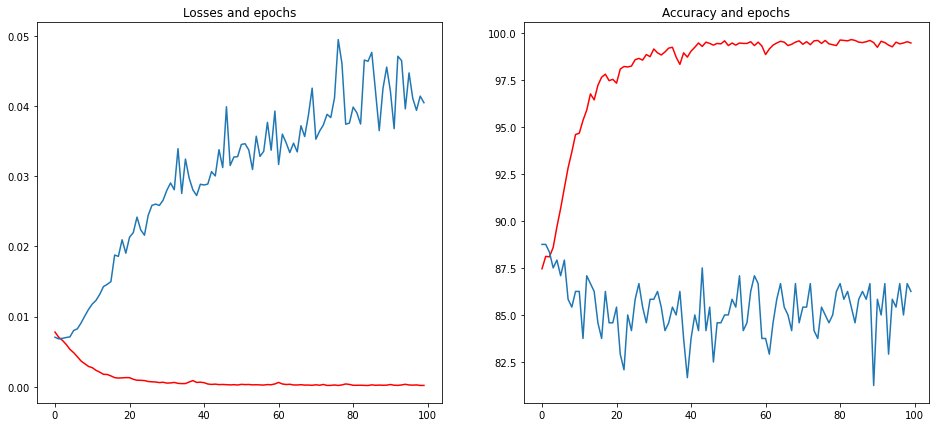

In [106]:
## Plot loss functions over epochs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))


ax1.plot(range(epochs), losses, c='r')
ax1.plot(range(epochs), losses_test)
ax1.set_title('Losses and epochs')

ax2.plot(range(epochs), accuracy, c='r')
ax2.plot(range(epochs), accuracy_test)
ax2.set_title("Accuracy and epochs")

plt.show()

In [107]:
# dictionary storing the data
summary = {
    "Training": [min(losses), max(accuracy)],
    "Test": [min(losses_test), max(accuracy_test)]
}

# dataframe from dict
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Loss', 'Accuracy'])

In [108]:
print('Spacy embeddings')
print(model)
print('learning_rate: ', learning_rate)
print('batch_size: ', batch_size)
print('time: ', duration)

Spacy embeddings
Model(
  (embedding): Embedding(10529, 96)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3840, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (out): Linear(in_features=1000, out_features=1, bias=True)
)
learning_rate:  0.001
batch_size:  50
time:  35.01638627052307


In [109]:
summary_df

,Loss,Accuracy
Training,0.000163,tensor(99.6364)
Test,0.006813,tensor(88.7500)
